<a href="https://colab.research.google.com/github/1900690/fisheye-distortion-correction/blob/main/%E9%AD%9A%E7%9C%BC%E8%A3%9C%E6%AD%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#AVIファイルをmp4に変換する

In [51]:
#失敗して元ファイルが破損するのを防ぐためにドライブからファイルコピー
import shutil
shutil.copytree("/content/drive/MyDrive/AVI", "/content/AVI")

'/content/AVI'

In [27]:
#libraryインポート
!pip install opencv-python
!pip install opencv-contrib-python

In [56]:
#AVIからmp4に変換　※動画が長いと失敗するのでひとつづつ行う
import cv2

file_path='/content/AVI/TLC00009.AVI'

if not os.path.exists('/content/mp4'):
    os.mkdir('/content/mp4')

#VideoCaptureオブジェクトを取得
cap = cv2.VideoCapture(file_path)

#動画のプロパティを取得
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

#書き出し設定
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
writer = cv2.VideoWriter("/content/mp4/"+os.path.splitext(os.path.basename(file_path))[0]+".mp4", fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    writer.write(frame)
    if not ret:
        break

writer.release()
cap.release()

In [37]:
#ファイルをドライブにコピー
import shutil
shutil.copyfile("/content/mp4/TLC00009.mp4", "/content/drive/MyDrive/mp4/TLC00009.mp4")

'/content/drive/MyDrive/mp4/TLC00009.mp4'

#mp4からjpgを取り出す

In [57]:
import shutil
import cv2
import os

#この中の動画が画像取り出しされる
LOAD_FOLDA = '/content/mp4'

if os.path.exists("/content/slice"):
  shutil.rmtree("/content/slice")

def save_frame_range(video_path,
                     dir_path, ext='jpg'):

    basename=video_path[-12:-4]
    cap = cv2.VideoCapture(video_path)

    # 総フレーム数
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT));
    #print(total_frames)

    #真ん中+1のフレームを取り出すプラスの数値を調整することでフレームをずらせる
    center_frame=total_frames
    start_frame=0#center_frame-1
    stop_frame=total_frames
    step_frame=total_frames#center_frame

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    for n in range(start_frame, stop_frame, step_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
        else:
            return

#スライスフォルダを作成
SAVE_NAME = 'slice'
if not os.path.exists('./' +SAVE_NAME):
    os.mkdir('./' +SAVE_NAME)

LOAD_NAME = os.listdir(LOAD_FOLDA)


for file_name in LOAD_NAME:
  IMAGE_PATH= LOAD_FOLDA +'/'+file_name
  save_frame_range(IMAGE_PATH,
                 '/content/'+SAVE_NAME)

image_date=LOAD_FOLDA[-8:]

In [ ]:
#画像をまとめてダウンロードするとき用
from google.colab import files
import shutil

shutil.make_archive('slice', format='zip', root_dir='/content/slice')

files.download('slice.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#魚眼補正

###参考
[魚眼レンズの補正](https://qiita.com/hiro_o_tama/items/cb544fe64ca373750aae)


[OpenCVのundistort（レンズ歪み補正）で端っこが欠けてしまうのをなんとかする](https://qiita.com/jellied_unagi/items/36796d48d7d8a5fb3e42)


[端っこをかけるのを防ぐために](http://twinklesmile.blog42.fc2.com/blog-entry-466.html)

In [58]:
import cv2
# assert cv2.__version__[0] == '3', 'このモジュールには3.0.0以上の opencv のバージョンが必要です'
import numpy as np
import os
import glob

#チェッカーボードの画像が入っているファイルのまでのパス、画像サイズはすべて同じである必要あり
images = glob.glob('/content/drive/MyDrive/checkboad/*.jpg')# source/*.jpg

#チェッカーボードのマス数（0から始まる）
CHECKERBOARD = (6,9)

#print(CHECKERBOARD)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)

#print('img end')
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("校正に有効な画像が" + str(N_OK) + "枚見つかりました")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

(6, 9)
img end
校正に有効な画像が6枚見つかりました
DIM=(1280, 720)
K=np.array([[768.4324165833522, 0.0, 629.193977277274], [0.0, 768.0867082519276, 363.13481714845415], [0.0, 0.0, 1.0]])
D=np.array([[-0.07176022472676662], [-0.01831839322401357], [-0.051792564889714565], [0.0897998816199078]])


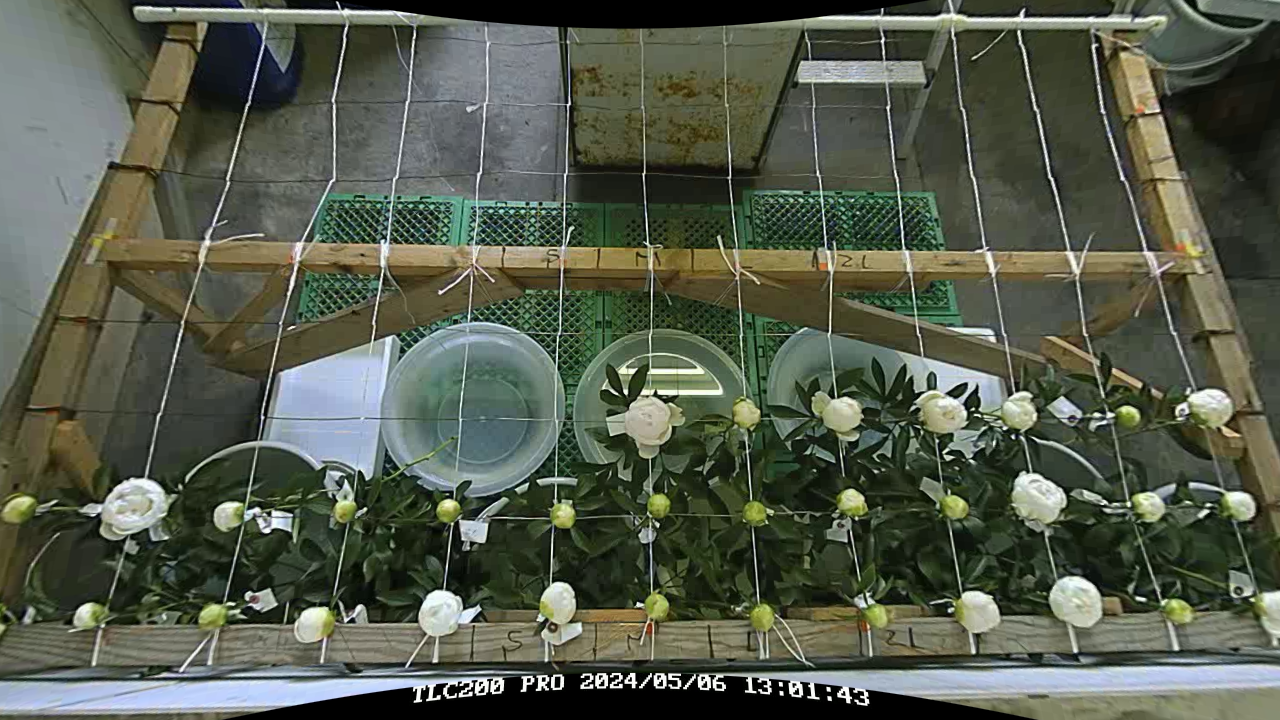

In [63]:
#指定した画像を構成値を用いて補正
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import sys
import os

#補正する画像のpath
p="/content/slice/TLC00016_000.jpg"

# 以下の3行を上のセルの出力に置き換えてください。
DIM=(1280, 720)
K=np.array([[768.4324165833522, 0.0, 629.193977277274], [0.0, 768.0867082519276, 363.13481714845415], [0.0, 0.0, 1.0]])
D=np.array([[-0.07176022472676662], [-0.01831839322401357], [-0.051792564889714565], [0.0897998816199078]])

#そのままのKだと大きく範囲を切り取ってしまうのでnkを使って補正
nK = K.copy()
nK[0,0]=K[0,0]/1.2
nK[1,1]=K[1,1]/1.2

#スライスフォルダを作成
if not os.path.exists('/content/adjusted/'):
    os.mkdir('/content/adjusted/')

def undistort(img_path):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    #map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), nK, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    cv2_imshow(undistorted_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    cv2.imwrite('/content/adjusted/out_' + os.path.basename(img_path), undistorted_img)

if __name__ == '__main__':
    undistort(p)